In [2]:
!pip install pulp

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 40.8 MB/s eta 0:00:00



--- Порівняння ---
Жадібний:             φ = 18.7034, час: 2.64 мс
Гібридна стратегія:   φ = 19.8462, час: 1400.30 мс


<ipython-input-20-df6f4cad1b86>:104: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', n)


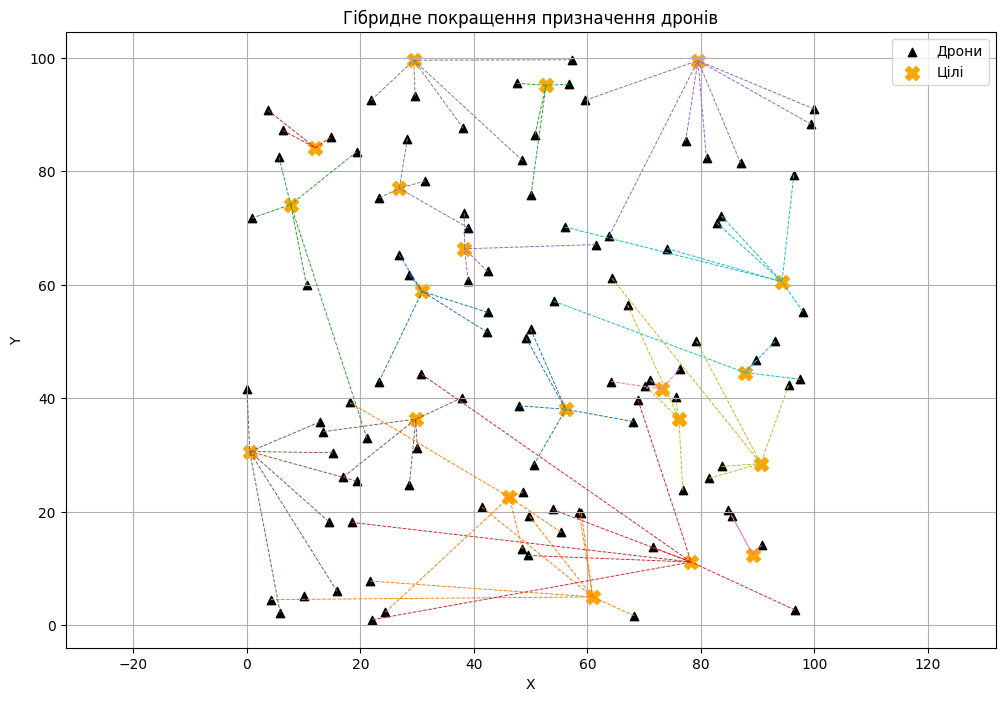

In [20]:
import pulp
import matplotlib.pyplot as plt
import numpy as np
import time
import pandas as pd
from copy import deepcopy

import time

# ==== ПАРАМЕТРИ ====
m = 100
n = 20
alpha = 0.05
eps = 1e-6

np.random.seed(int(time.time()) % (2**32 - 1))
# np.random.seed(42)
drone_coords = np.random.rand(m, 2) * 100
target_coords = np.random.rand(n, 2) * 100
fuel = np.random.uniform(25, 70, size=m)

distances = np.linalg.norm(drone_coords[:, None, :] - target_coords[None, :, :], axis=2)
probabilities = 1 / (1 + alpha * distances)

def compute_phi(assignments, probabilities):
    n = probabilities.shape[1]
    phi = 0.0
    for j in range(n):
        product = 1.0
        for (i, jj) in assignments:
            if jj == j:
                product *= (1 - probabilities[i][j])
        phi += 1 - product
    return phi

def greedy_assignment(probabilities, distances, fuel):
    greedy_assignments = []
    for i in range(probabilities.shape[0]):
        best_j = -1
        best_p = -1
        for j in range(probabilities.shape[1]):
            if distances[i][j] <= fuel[i] and probabilities[i][j] > best_p:
                best_j = j
                best_p = probabilities[i][j]
        if best_j != -1:
            greedy_assignments.append((i, best_j))
    return greedy_assignments

def local_search(assignments, distances, probabilities, fuel):
    current = deepcopy(assignments)
    current_phi = compute_phi(current, probabilities)
    improved = True
    while improved:
        improved = False
        for idx, (i, j) in enumerate(current):
            best_j = j
            best_phi = current_phi
            for j_new in range(probabilities.shape[1]):
                if j_new == j or distances[i][j_new] > fuel[i]:
                    continue
                candidate = deepcopy(current)
                candidate[idx] = (i, j_new)
                phi_candidate = compute_phi(candidate, probabilities)
                if phi_candidate > best_phi:
                    best_j = j_new
                    best_phi = phi_candidate
            if best_j != j:
                current[idx] = (i, best_j)
                current_phi = best_phi
                improved = True
    return current, current_phi

# ==== ЖАДІБНИЙ ====
start_greedy = time.time()
greedy_assignments = greedy_assignment(probabilities, distances, fuel)
phi_greedy = compute_phi(greedy_assignments, probabilities)
end_greedy = time.time()

# ==== ГІБРИДНИЙ (лінійна + локальний) ====
start_hybrid = time.time()

model = pulp.LpProblem("Drone_Target_Assignment", pulp.LpMaximize)
x = pulp.LpVariable.dicts("x", ((i, j) for i in range(m) for j in range(n)), cat="Binary")
model += pulp.lpSum(probabilities[i][j] * x[i, j] for i in range(m) for j in range(n))
for i in range(m):
    model += pulp.lpSum(x[i, j] for j in range(n)) <= 1
    model += pulp.lpSum(distances[i][j] * x[i, j] for j in range(n)) <= fuel[i]
    for j in range(n):
        if distances[i][j] > fuel[i] + eps:
            model += x[i, j] == 0
model.solve()

assignments = [(i, j) for i in range(m) for j in range(n) if pulp.value(x[i, j]) == 1]
initial_phi = compute_phi(assignments, probabilities)
optimized_assignments, final_phi = local_search(assignments, distances, probabilities, fuel)
end_hybrid = time.time()

# ==== ПОРІВНЯННЯ ====
print("\n--- Порівняння ---")
print(f"Жадібний:             φ = {phi_greedy:.4f}, час: {((end_greedy - start_greedy) * 1000):.2f} мс")
print(f"Гібридна стратегія:   φ = {final_phi:.4f}, час: {((end_hybrid - start_hybrid) * 1000):.2f} мс")

# ==== ВІЗУАЛІЗАЦІЯ ====
colors = plt.cm.get_cmap('tab10', n)
plt.figure(figsize=(12, 8))
plt.scatter(drone_coords[:, 0], drone_coords[:, 1], c='black', label='Дрони', marker='^')
plt.scatter(target_coords[:, 0], target_coords[:, 1], c='orange', label='Цілі', marker='X', s=100)
for (i, j) in optimized_assignments:
    plt.plot([drone_coords[i, 0], target_coords[j, 0]],
             [drone_coords[i, 1], target_coords[j, 1]],
             linestyle='--', color=colors(j), linewidth=0.7)
plt.title('Гібридне покращення призначення дронів')
plt.xlabel('X')
plt.ylabel('Y')
plt.grid(True)
plt.axis('equal')
plt.legend()
plt.show()
